<center><img src="ImgProb02G03.png"></center>

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import MEF as mef
from tqdm.auto import tqdm

In [2]:
lc = 0.03
h = 0.3  # m
b = 0.6  # m
v = 0.3  # coef Poisson
Ei = 206e9  # Pa 
r = 0.03  # m  radio del agujero
t = 0.03  # m  espesor de la chapa
T = 10e6  # Pa

In [3]:
gmsh.initialize()
gmsh.model.add('Chapa_agujero_central')

In [4]:
pc = gmsh.model.geo.addPoint(b/2,0,0,lc)
p1 = gmsh.model.geo.addPoint(0,0,0,lc)
p2 = gmsh.model.geo.addPoint(b/2-r,0,0,lc)
p3 = gmsh.model.geo.addPoint(b/2,r,0,lc/40)
p4 = gmsh.model.geo.addPoint(b/2+r,0,0,lc)
p5 = gmsh.model.geo.addPoint(b,0,0,lc)
p6 = gmsh.model.geo.addPoint(b,h/2,0,lc)
p7 = gmsh.model.geo.addPoint(0,h/2,0,lc)

l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p4,p5)
l3 = gmsh.model.geo.addLine(p5,p6)  # traccionada
l4 = gmsh.model.geo.addLine(p6,p7)
l5 = gmsh.model.geo.addLine(p7,p1)  # traccionada  
c1 = gmsh.model.geo.addCircleArc(p2, pc, p3)
c2 = gmsh.model.geo.addCircleArc(p3, pc, p4)

C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4,l5,c1,c2])

S1 = gmsh.model.geo.addPlaneSurface([C1])

p9 = gmsh.model.geo.addPoint(b/2,r+(1/12)*(h/2-r),0,lc/40)
p10 = gmsh.model.geo.addPoint(b/2,r+(2/12)*(h/2-r),0,lc/40)
p11 = gmsh.model.geo.addPoint(b/2,r+(3/12)*(h/2-r),0,lc/40)
p12 = gmsh.model.geo.addPoint(b/2,r+(4/12)*(h/2-r),0,lc/40)
p13 = gmsh.model.geo.addPoint(b/2,r+(5/12)*(h/2-r),0,lc/40)
p14 = gmsh.model.geo.addPoint(b/2,r+(6/12)*(h/2-r),0,lc/40)
p15 = gmsh.model.geo.addPoint(b/2,r+(7/12)*(h/2-r),0,lc/40)
p16 = gmsh.model.geo.addPoint(b/2,r+(8/12)*(h/2-r),0,lc/40)
p17 = gmsh.model.geo.addPoint(b/2,r+(9/12)*(h/2-r),0,lc/40)
p18 = gmsh.model.geo.addPoint(b/2,r+(10/12)*(h/2-r),0,lc/40)
p19 = gmsh.model.geo.addPoint(b/2,r+(11/12)*(h/2-r),0,lc/40)
p20 = gmsh.model.geo.addPoint(b/2,r+(11.9/12)*(h/2-r),0,lc/40)

gmsh.model.geo.synchronize()

gmsh.model.mesh.embed(0, [p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20], 2, S1)

gmsh.model.mesh.generate(2)
gmsh.model.geo.synchronize()
gmsh.fltk.run()

Traccionado_pos = gmsh.model.addPhysicalGroup(1,[l3])
gmsh.model.setPhysicalName(1,Traccionado_pos,'Traccionado_pos')
Traccionado_neg = gmsh.model.addPhysicalGroup(1,[l5])
gmsh.model.setPhysicalName(1,Traccionado_neg,'Traccionado_neg')
Empotrado_y = gmsh.model.addPhysicalGroup(1, [l1,l2])
gmsh.model.setPhysicalName(1,Empotrado_y,'Empotrado en y')
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

In [5]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)   # ETAGS = numeracion de cada elemento
                                                            # ELEMENTS = ravel de los nodos que posee cada elemento
MN = NodeInfo[1].reshape(Nn,3)  # matriz coordenadas de los nodos
# MN = np.append(MN[1:,:],[MN[0,:]],0)  # llevo la primer fila al final porque nombra al nodo del centro como el último taggeado
MC = ELEMENTS.reshape(ETAGS.shape[0],3)  # matriz conectividad
Ne, Nnxe = MC.shape
MC = MC - np.ones([Ne,Nnxe])  # resto 1 para acomodar a lenguaje python

E = np.zeros(Ne)
for e in range(Ne):
    E[e] = Ei
    
glxn = 2
dimension_elementos = 2

gmsh.option.setNumber("Mesh.MshFileVersion",2.2)
gmsh.write('chapa_agujero.msh')

In [6]:
nodos_empot_y, xyz_empot_y = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_y)

In [7]:
s = []  # el vector s indica la direccion de que nodo sabemos cuanto se desplaza.
        # en este caso se asignan los valores de las direcciones de cada nodo empotrado
for n in nodos_empot_y-1:
    s.append(glxn*n+1)

s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn+1)

s = np.array(s).astype(int)

Us = np.zeros([s.shape[0]]).reshape([-1,1])

r = mef.vector_complemento(s, MN, glxn).astype(int)

In [8]:
entityTraccionada_pos = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado_pos)
Tgroup_pos, Ttraccionada_pos, Ltraccionada_pos = gmsh.model.mesh.getElements(1, entityTraccionada_pos[0])
Nlineastraccionadas_pos = len(Ttraccionada_pos[0])
MCtraccionadas_pos = Ltraccionada_pos[0].reshape(Nlineastraccionadas_pos,2)-1

entityTraccionada_neg = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado_neg)
Tgroup_neg, Ttraccionada_neg, Ltraccionada_neg = gmsh.model.mesh.getElements(1, entityTraccionada_neg[0])
Nlineastraccionadas_neg = len(Ttraccionada_neg[0])
MCtraccionadas_neg = Ltraccionada_neg[0].reshape(Nlineastraccionadas_neg,2)-1

Fr = np.zeros_like(r)  # Vector fuerzas en los nodos que empotrados
for e in range(Nlineastraccionadas_pos):
    nodo1 = MCtraccionadas_pos[e,0].astype(int)
    nodo2 = MCtraccionadas_pos[e,1].astype(int)
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])  # Longitud de la linea traccionada [e] que se esta analizando
    Fr[np.where(r == nodo1*2)[0][0]] += T*Ltraccionado*t/2  # Se distribuye la tensión aplicada según la longitud del elemento
    Fr[np.where(r == nodo2*2)[0][0]] += T*Ltraccionado*t/2
for e in range(Nlineastraccionadas_neg):
    nodo1 = MCtraccionadas_neg[e,0].astype(int)
    nodo2 = MCtraccionadas_neg[e,1].astype(int)
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])  # Longitud de la linea traccionada [e] que se esta analizando
    Fr[np.where(r == nodo1*2)[0][0]] += -T*Ltraccionado*t/2  # Se distribuye la tensión aplicada según la longitud del elemento
    Fr[np.where(r == nodo2*2)[0][0]] += -T*Ltraccionado*t/2
Fr = Fr.reshape([-1,1])

In [9]:
K, Ke, D, B = mef.Kglobal_barra(MN, MC, E, glxn, dimension_elementos, v,t) 

F, U = mef.solve(K, r, s, Us, Fr)

sig = mef.tensiones(MC, U, D, B, glxn)
sig_xytau = np.hstack(list(sig.values()))

In [10]:
U2D = U.reshape(Nn,glxn)
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)

In [11]:
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Chapa_agujero_central', 'NodeData', NodeInfo[0]+1, U3D, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

F2D = F.reshape(Nn,glxn)
F3D = np.append(F2D,np.zeros(F2D.shape[0]).reshape([-1,1]),1)

fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Chapa_agujero_central','NodeData',NodeInfo[0]+1, F3D, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType',4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation',2)

sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[0,:].reshape([-1,1]), numComponents=1)  # hago reshape porque tienen que ir vectores columnas
SIGY = gmsh.view.addModelData(sigy, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

gmsh.fltk.run()

<center><img src="FF3_sin_fisura.png"></center>

$ 
\text{Para medir la longitud de la fisura (aproximada): Se tienen en cuenta las coordenadas del primer elemento eliminado y del último.}
$

$ 
\text{1ro: Creo una matriz que almacene los nodos de cada elemento eliminado}
$

$ 
\text{2do: Considero que la fisura tiende a ser como una linea recta}
$

$
\text{3ro: Obtengo la distancia entre dos puntos, un punto es un nodo del primer elemento eliminado, y el otro punto es un nodo del último elemento eliminado}
$

$ 
\text{4to: Del primer elemento se toma el nodo de menor distancia en y. Del último elemento se toma el nodo con mayor distancia en y}
$

In [12]:
MCbroken = MC
ETAGSbroken = ETAGS
ElementosRotos = 175  # usar siempre impar
MC_eliminados = np.zeros(3)
longfisuras = np.zeros([ElementosRotos+1,1])  
T_MAIN_MAX = np.zeros([ElementosRotos+1,1])  # almacena las tensiones principales máximas de los elementos eliminados
long_fis = 0

MCmovie = {}
MNmovie = {}
MCmovie[0] = MCbroken
MNmovie[0] = MN

progress = tqdm(range(ElementosRotos))

for elrot in progress:
    
    T_main_max = np.array([(sig_xytau[0,:]+sig_xytau[1,:])/2+np.sqrt(((sig_xytau[0,:]-sig_xytau[1,:])/2)**2+sig_xytau[2,:]**2)])  # tensiones principales máximas de todos los elementos
    
    T_MAIN_MAX[elrot] = np.array([T_main_max.max()])
    
    max_sig_element = np.where(T_main_max == T_main_max.max())[1]  # elemento de máxima sigma_x aplicada
    
    MC_eliminados = np.vstack([MC_eliminados,MCbroken[max_sig_element]])
    MCbroken = np.delete(MCbroken, max_sig_element, axis=0)
    ETAGSbroken = np.delete(ETAGSbroken, max_sig_element, axis=0)
    Ne, Nnxe = MCbroken.shape
    E = np.zeros(Ne)
    for e in range(Ne):
        E[e] = Ei
    K, Ke, D, B = mef.Kglobal_barra(MN, MCbroken, E, glxn, dimension_elementos, v,t)
    F, U = mef.solve(K, r, s, Us, Fr)
    sig = mef.tensiones(MCbroken, U, D, B, glxn)
    sig_xytau = np.hstack(list(sig.values()))  # saco las tensiones del diccionario, quedan en filas para cada elemento las tensiones x, y, xy
    U2D = U.reshape(Nn,glxn)
    
    U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)
    
    U3D[:,0] = U3D[:,0]*10**(3.1)
    U3D[:,1] = U3D[:,1]*10**(2.5)
    MNdef = MN + U3D

    MCmovie[elrot+1] = MCbroken
    MNmovie[elrot+1] = MNdef
    
T_MAIN_MAX[elrot+1] = np.array([T_main_max.max()])

MC_eliminados = np.delete(MC_eliminados,0,0)

el1_nodos = MC_eliminados[0].astype(int)
el1_coord = np.array([[MN[el1_nodos[0]]],[MN[el1_nodos[1]]],[MN[el1_nodos[2]]]])
cd_in = el1_coord[np.where(el1_coord == el1_coord[:,0][:,1].min())[0][0]].tolist()[0]  # coord del nodo donde inicia la fisura

for n in range(ElementosRotos):
    el2_nodos = MC_eliminados[n].astype(int)
    el2_coord = np.array([[MN[el2_nodos[0]]],[MN[el2_nodos[1]]],[MN[el2_nodos[2]]]])
    cd_p = el2_coord[np.where(el2_coord == el2_coord[:,0][:,1].max())[0][0]].tolist()[0]  # coord del nodo en la punta de la fisura
    long_fis = ((cd_p[0]-cd_in[0])**2+(cd_p[1]-cd_in[1])**2)**(1/2)
    longfisuras[n+1] = np.array([long_fis])

  0%|          | 0/175 [00:00<?, ?it/s]

$$
$$

In [13]:
# analizo la cantidad de elementos pares e impares
# sumo 1 para que tambien grafique las condiciones máximas cuando no se elimino ningun elemento
longfisuras_par = np.zeros([int(ElementosRotos/2)+1,1])
longfisuras_impar = np.zeros([int(ElementosRotos/2)+1,1])
T_MAIN_MAX_par = np.zeros([int(ElementosRotos/2)+1,1])
T_MAIN_MAX_impar = np.zeros([int(ElementosRotos/2)+1,1])

for elrot in range(int(ElementosRotos/2)+1):
    longfisuras_par[elrot] = longfisuras[elrot*2+1]
    longfisuras_impar[elrot] =longfisuras[elrot*2]
    T_MAIN_MAX_par[elrot] = T_MAIN_MAX[elrot*2+1]
    T_MAIN_MAX_impar[elrot] = T_MAIN_MAX[elrot*2]

$ \Large \underline{
\text{Gráfico Tensiones Principales Máximas vs Longitud de la Fisura}}
$

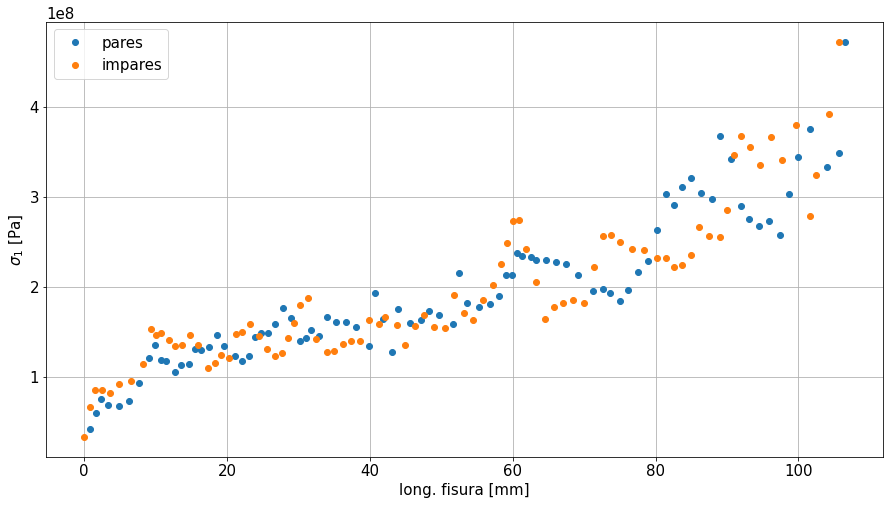

In [14]:
plt.rc('figure', figsize=(15, 8))
plt.rc('font', size=15)
plt.plot(longfisuras_par*1000,T_MAIN_MAX_par,'o',label='pares')
plt.plot(longfisuras_impar*1000,T_MAIN_MAX_impar,'o',label='impares')
plt.grid()
plt.ylabel('$\sigma_{1}$ [Pa]')
plt.xlabel('long. fisura [mm]')
plt.legend()
plt.show()

Se observa que a medida que la longitud de la fisura avanza, la tensión en la punta de la fisura aumenta, esto también puede interpretarse como un aumento de la velocidad de propagación. 

In [15]:
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Chapa_agujero_central', 'NodeData', NodeInfo[0]+1, U3D, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

F2D = F.reshape(Nn,glxn)
F3D = np.append(F2D,np.zeros(F2D.shape[0]).reshape([-1,1]),1)

fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Chapa_agujero_central','NodeData',NodeInfo[0]+1, F3D, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType',4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation',2)

sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Chapa_agujero_central', 'ElementData', ETAGSbroken, sig_xytau[0,:].reshape([-1,1]), numComponents=1)  # hago reshape porque tienen que ir vectores columnas
SIGY = gmsh.view.addModelData(sigy, 0, 'Chapa_agujero_central', 'ElementData', ETAGSbroken, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

gmsh.fltk.run()

En las siguientes imagenes se muestran resultados de la zona donde se propaga la fisura:

<center><img src="FFisura_Hermosa(21).png"></center>

<center><img src="FFisura_Hermosa(zoom)(21).png"></center>

In [16]:
!mkdir images3.1
!mkdir images3.2

In [17]:
P = np.linspace(1,ElementosRotos,ElementosRotos).astype(int)

prop = 15  # hasta que elemento se propaga lento la fisura, por ahora es hipotético

for p in range(prop):
    fig, ax = plt.subplots(figsize=(30,30/4))
    ax = plt.triplot(MNmovie[P[p]][:,0], MNmovie[P[p]][:,1], MCmovie[P[p]], label='Fisura',color='black')
    plt.xlim(-0.05,0.65)
    plt.ylim(0,0.18)
    plt.savefig(f'images3.1/{P[p]:003}', dpi=100, facecolor='white')
    plt.close()
    
for p in range(prop,ElementosRotos,2):
    fig, ax = plt.subplots(figsize=(30,30/4))
    ax = plt.triplot(MNmovie[P[p]][:,0], MNmovie[P[p]][:,1], MCmovie[P[p]], label='Fisura',color='black')
    plt.xlim(-0.05,0.65)
    plt.ylim(0,0.18)
    plt.savefig(f'images3.2/{P[p]:003}', dpi=100, facecolor='white')
    plt.close()
    
!magick convert -delay 120 images3.1/*.png -delay 5 images3.2/*.png FFIS11_GIF.gif

In [18]:
!mkdir images3.3
!mkdir images3.4

In [19]:
for p in range(prop):
    fig, ax = plt.subplots(figsize=(30,30/4))
    ax = plt.plot(longfisuras[:p]*1000,T_MAIN_MAX[:p],'o',color='black')
    plt.ylabel('$\sigma_{1}$ [Pa]')
    plt.xlabel('long. fisura [mm]')
    plt.xlim(-2,120)
    plt.ylim(0,4.5*1e8)
    plt.savefig(f'images3.3/{P[p]:003}', dpi=100, facecolor='white')
    plt.close()
    
for p in range(prop,ElementosRotos,2):
    fig, ax = plt.subplots(figsize=(30,30/4))
    ax = plt.plot(longfisuras[:p]*1000,T_MAIN_MAX[:p],'o',color='black')
    plt.ylabel('$\sigma_{1}$ [Pa]')
    plt.xlabel('long. fisura [mm]')
    plt.xlim(-2,120)
    plt.ylim(0,4.5*1e8)
    plt.savefig(f'images3.4/{P[p]:003}', dpi=100, facecolor='white')
    plt.close()
    
!magick convert -delay 120 images3.3/*.png -delay 5 images3.4/*.png TENLONG11_GIF.gif

![alt text](FFIS11_GIF.gif "Title")

![alt text](TENLONG11_GIF.gif "Title")